# Analyzing Unstructured Survey Responses with Text Embeddings
## ABB #1 - Session 4

Code authored by: Shaw Talebi

### imports

In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from openai import OpenAI
from top_secret import my_sk

import os 
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### functions

In [2]:
def format_responses(response_series):
    """
        Format responses from pandas series into a string for an LLM to understand
    """
    
    responses_string = ""
    for response in response_series:
        responses_string = responses_string + "- " + str(response) + "\n"

    return responses_string

In [3]:
def summarize_responses(my_sk, response_series):
    """
        Summarize survey dream outcomes with GPT-4o-mini
    """

    # setup api client
    client = OpenAI(api_key=my_sk)

    # construct prompt
    responses_string = format_responses(response_series)
    prompt = f"""Given the following pre-course survey responses to the question "What is your dream outcome for this course?", geneate a single label that describes the respondants e.g. product entrepreners, career developers, etc.: 
    {responses_string}
    """
    
    # make api call
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "user", "content": prompt}
        ], 
        temperature = 0.25
    )
    
    # extract response
    summary = response.choices[0].message.content
    return summary

### load survey data

In [4]:
df = pd.read_csv('data/survey.csv')
df.columns = ["Timestamp", "ai_exp", "prog_exp", "prog_langs", "dream_outcome", "availability", "notes"]
df.head()

,Timestamp,ai_exp,prog_exp,prog_langs,dream_outcome,availability,notes
0,2024/10/23 3:50:16 PM CST,1-3 years,4-6 years,Python,"Hands on projects, and switch to Data science...",6-10,Really excited about the course
1,2024/10/23 11:10:31 PM CST,1-3 years,4-6 years,Python,"Get to know Shaw better! Plus, have a clear pa...",5,NaN
2,2024/10/24 2:28:16 AM CST,<1 year,<1 year,Python,"Fundamentals understanding, Hands on skills, s...",It depends if I find it interesting,Answers correspond to specific Ai hands on ski...
3,2024/10/24 3:18:45 AM CST,4-6 years,7+ years,Python,Build multiple AI applications,2,NaN
4,2024/10/24 6:26:56 AM CST,<1 year,7+ years,"PHP, Javascript",I would like to learn how to practically setup...,10,NaN


### encode dream outcomes

In [5]:
# load model
model = SentenceTransformer("all-MiniLM-L12-v2")

In [6]:
# compute embeddings
embeddings = model.encode(df['dream_outcome'])
print(embeddings.shape)

(37, 384)


### Cluster responses based on similarity

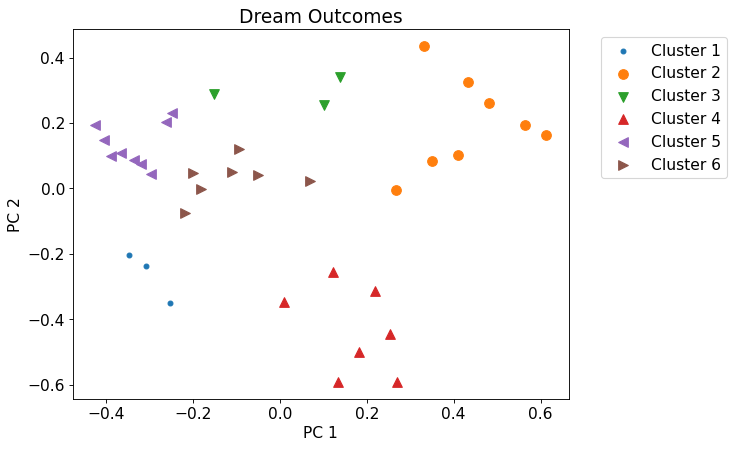

In [7]:
from sklearn.cluster import KMeans

N = 6
X = PCA(n_components=2).fit_transform(embeddings)
kmeans = KMeans(n_clusters=N, random_state=0, n_init="auto").fit(X)


plt.figure(figsize=(8, 6), dpi=80)
plt.rcParams.update({'font.size': 14})
marker_list = ['.', 'o', 'v', '^', '<', '>', '1', '2']

for i in range(N):
    plt.scatter(X[kmeans.labels_==i, 0], X[kmeans.labels_==i, 1], label=f"Cluster {i+1}", s=75, marker=marker_list[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Dream Outcomes")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

### Summarize responses by cluster

In [8]:
for i in range(N):
    response_series = df['dream_outcome'][kmeans.labels_==i]
    print("Cluster", i+1, "| Size:", len(response_series))
    print("Responses:")
    print(format_responses(response_series))
    print("Description:", summarize_responses(my_sk, response_series))
    print("-------------------------------------")

Cluster 1 | Size: 3
Responses:
- Build multiple AI applications
- Be able to create and deploy my own Ai powered apps
- Build my own AI product with the AI services available these days

Description: AI Product Developers
-------------------------------------
Cluster 2 | Size: 8
Responses:
- Hands on projects,  and switch to Data science career path from research
- Get to know Shaw better! Plus, have a clear path with resources to guide you on where to go and what to do for the future
- Fundamentals understanding, Hands on skills, small projects running in diff frameworks, create a small GH portfolio.
- Learn to decide and advice between different data science archictures and options
- Get a new job
- Be able to be comfortable with GenAi
- A certificate to showcase my new skills,  A jump start to do my own programing and be able to communicate with programmers
- Landing a new job

Description: **Career Transitioners in Data Science**
-------------------------------------
Cluster 3 | Si